In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import csv
import matplotlib.pyplot as plt

In [2]:
trainfile_path =  'G:/kaggle/digit-recognizer/train.csv'
testfile_path =  'G:/kaggle/digit-recognizer/test.csv'

In [46]:
#读入训练集数据
train_file = []
with open(trainfile_path) as f:
    lines = csv.reader(f)
    for line in lines:
        train_file.append(line)

train_file = np.array(train_file)
train_file = np.delete(train_file,0,axis = 0)
train_data = train_file[:29400,1:].astype(float)
valid_data = train_file[29400:,1:].astype(float)


In [47]:
train_label = torch.LongTensor(train_file[:29400,0].astype(float))
valid_label = torch.LongTensor(train_file[29400:,0].astype(float))

In [48]:
#读入测试集数据
test_file = []
with open(testfile_path) as f:
    lines = csv.reader(f)
    for line in lines:
        test_file.append(line)

test_file = np.array(test_file)
test_data = test_file[1:,:].astype(float)


In [49]:
train_data = np.multiply(train_data, 1.0/255.0)
valid_data = np.multiply(valid_data, 1.0/255.0)
test_data = np.multiply(test_data, 1.0/255.0)

In [50]:
train_set_raw = torch.FloatTensor(train_data.reshape((train_data.shape[0], 1, 28,28)))
valid_set_raw = torch.FloatTensor(valid_data.reshape((valid_data.shape[0], 1, 28,28)))
test_set_raw = torch.FloatTensor(test_data.reshape((test_data.shape[0], 1, 28,28)))

In [2]:
from torchvision import transforms as tfs
def train_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(32),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(28),
        tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        tfs.ToTensor(),
    ])
    x = im_aug(x)
    return x

In [289]:
train_set_raw2 = torch.zeros(train_set_raw.shape[0], 1, 28, 28)
for i in range(0,train_set_raw.shape[0]):
    train_set_raw2[i] = train_tf(tfs.ToPILImage()(train_set_raw[i]))

In [337]:
train_set_raw3 = torch.cat([train_set_raw,train_set_raw2],dim = 0)
train_label3 = torch.cat([train_label,train_label],dim = -1)

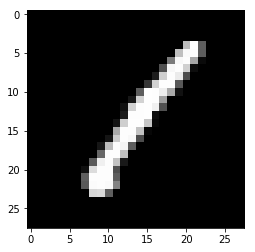

In [294]:
plt.imshow(train_set_raw[0][0],cmap='gray')

In [339]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,30,3,1,1,dilation = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(30,60,3,1,1,dilation = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(60,120,3,1,1,dilation = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(120,200,3,1,1,dilation = 7),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            )
        self.fc = nn.Sequential(
                nn.Linear(120 * 3 * 3, 500),
                nn.Dropout(0.5),
                nn.ReLU(True),
                nn.Linear(500, 10),
#                 nn.ReLU(True),
#                 nn.Linear(100, 10),
            
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
      #  x = self.conv4(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        
        return output
        

In [340]:
cnn = CNN()

In [341]:
epoch = 20
batchsize = 128
optimizer = torch.optim.Adam(cnn.parameters())
criterion = nn.CrossEntropyLoss()

In [342]:
import torch.utils.data as Data
train_set = Data.TensorDataset(train_set_raw3,train_label3)
train_set = Data.DataLoader(dataset = train_set,batch_size = batchsize,shuffle = True)
valid_set = Data.TensorDataset(valid_set_raw,valid_label)
valid_set = Data.DataLoader(dataset = valid_set,batch_size = batchsize,shuffle = True)

In [350]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
if torch.cuda.is_available():
    cnn = cnn.cuda()

for e in range(epoch):
    train_loss = 0
    train_acc = 0
    cnn.train()
    for im, label in train_set:
        if torch.cuda.is_available():
            im = Variable(im.cuda())  
            label = Variable(label.cuda())  
        else:
            im = Variable(im)
            label = Variable(label)
        
        # 前向传播
        out = cnn(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_set))
    acces.append(train_acc / len(train_set))
    
    #保存模型    
    torch.save(cnn, 'cnn_'+ str(e)+ '.pth')
    
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    cnn.eval() # 将模型改为预测模式
    for im, label in valid_set:
        if torch.cuda.is_available():
            im = Variable(im.cuda())  
            label = Variable(label.cuda())  
        else:
            im = Variable(im)
            label = Variable(label)
        out = cnn(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(valid_set))
    eval_acces.append(eval_acc / len(valid_set))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_set), train_acc / len(train_set), 
                     eval_loss / len(valid_set), eval_acc / len(valid_set)))

epoch: 0, Train Loss: 0.013188, Train Acc: 0.995873, Eval Loss: 0.035725, Eval Acc: 0.992323
epoch: 1, Train Loss: 0.014204, Train Acc: 0.995533, Eval Loss: 0.042792, Eval Acc: 0.991162
epoch: 2, Train Loss: 0.014534, Train Acc: 0.995177, Eval Loss: 0.038036, Eval Acc: 0.991556
epoch: 3, Train Loss: 0.011339, Train Acc: 0.996315, Eval Loss: 0.038266, Eval Acc: 0.992424
epoch: 4, Train Loss: 0.011620, Train Acc: 0.996213, Eval Loss: 0.034542, Eval Acc: 0.993608
epoch: 5, Train Loss: 0.014631, Train Acc: 0.995737, Eval Loss: 0.040865, Eval Acc: 0.991849
epoch: 6, Train Loss: 0.014300, Train Acc: 0.995652, Eval Loss: 0.035823, Eval Acc: 0.992582
epoch: 7, Train Loss: 0.009465, Train Acc: 0.996773, Eval Loss: 0.054408, Eval Acc: 0.990959
epoch: 8, Train Loss: 0.007554, Train Acc: 0.997622, Eval Loss: 0.039522, Eval Acc: 0.992740
epoch: 9, Train Loss: 0.011087, Train Acc: 0.996501, Eval Loss: 0.049290, Eval Acc: 0.992109
epoch: 10, Train Loss: 0.013366, Train Acc: 0.995873, Eval Loss: 0.044

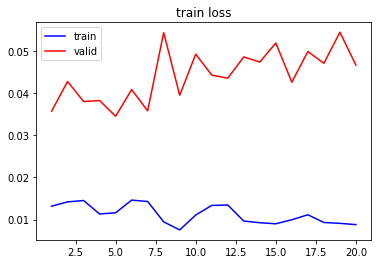

In [351]:
from matplotlib.pyplot import MultipleLocator #导入此类，设置坐标轴间隔
plt.title('train loss')

#令x轴刻度间隔为1，当回合数很多时，可适当增大间隔或取消运行以下三行
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

plt.plot(np.arange(1,len(losses)+1),losses, c = 'b',label = 'train')
plt.plot(np.arange(1,len(eval_losses)+1), eval_losses,c = 'r',label = 'valid')
plt.legend()

In [227]:
test_set = Data.DataLoader(dataset = test_set_raw, batch_size = batchsize, shuffle = False)

In [352]:
#加载相应的CNN模型
cnn = torch.load('cnn_4.pth')

In [353]:
predicted_labels = []
for im in test_set:
        if torch.cuda.is_available():
            im = Variable(im.cuda())  
        else:
            im = Variable(im)
        out = cnn(im)
        _, pred = out.max(1)
        predicted_labels = predicted_labels + pred.tolist()

In [354]:
import pandas as pd
dataframe = pd.DataFrame(np.c_[range(1,len(test_set_raw)+1),predicted_labels],columns = ['ImageId','Label'])
dataframe.to_csv('predicted_csv.csv',index = 0)